Parts of this assignment will be **automatically graded**. Please take note of the following:
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- You can add additional cells, but it is not recommended to (re)move cells. Cells required for autograding cannot be moved and cells containing tests cannot be edited.
- You are allowed to use a service such as [Google Colaboratory](https://colab.research.google.com/) to work together. However, you **cannot** hand in the notebook that was hosted on Google Colaboratory, but you need to copy your answers into the original notebook and verify that it runs succesfully offline. This is because Google Colaboratory destroys the metadata required for grading.
- Name your notebook **exactly** `{TA_name}_{student1_id}_{student2_id}_lab{i}.ipynb`, for example `wouter_12345_67890_lab1.ipynb` (or tim|elise|david|qi, depending on your TA), **otherwise your submission will be skipped by our regex and you will get 0 points** (but no penalty as we cannot parse your student ids ;)).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names below:

In [1]:
NAMES = "David Speck, Victor Zuanazzi"

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

---
## 1. Policy Evaluation (1 point)

In this exercise we will evaluate a policy, e.g. find the value function for a policy. The problem we consider is the gridworld from Example 4.1 in the book. The environment is implemented as `GridworldEnv`, which is a subclass of the `Env` class from [OpenAI Gym](https://github.com/openai/gym). This means that we can interact with the environment. We can look at the documentation to see how we can interact with the environment.

In [3]:
from gridworld import GridworldEnv
env = GridworldEnv()
# Lets see what this is
?env

In [4]:
# To have a quick look into the code
??env

Now we want to evaluate a policy by using Dynamic Programming. For more information, see the [Intro to RL](https://drive.google.com/open?id=1opPSz5AZ_kVa1uWOdOiveNiBFiEOHjkG) book, section 4.1. This algorithm requires knowledge of the problem dynamics in the form of the transition probabilities $p(s',r|s,a)$. In general these are not available, but for our gridworld we know the dynamics and these can be accessed as `env.P`.

In [5]:
# Take a moment to figure out what P represents. 
# Note that this is a deterministic environment. 
# What would a stochastic environment look like?
env.P

{0: {0: [(1.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True)],
  2: [(1.0, 0, 0.0, True)],
  3: [(1.0, 0, 0.0, True)]},
 1: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 2, -1.0, False)],
  2: [(1.0, 5, -1.0, False)],
  3: [(1.0, 0, -1.0, True)]},
 2: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 6, -1.0, False)],
  3: [(1.0, 1, -1.0, False)]},
 3: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 7, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 4: {0: [(1.0, 0, -1.0, True)],
  1: [(1.0, 5, -1.0, False)],
  2: [(1.0, 8, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 5: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 6, -1.0, False)],
  2: [(1.0, 9, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 6: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 10, -1.0, False)],
  3: [(1.0, 5, -1.0, False)]},
 7: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 11, -1.0, False)],
  3: [(1.0, 6, -1.0, False)]},
 8: {0: [(1.0, 4

In [6]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    Implementation of Iterative Policy Evaluation, Chapter 4, pag 75 from Sutton
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    
    max_delta = theta + 1  # Arbitrary initialization to enter the evaluation loop.
    
    while max_delta > theta:
        
        # Resets max_delta to store the max change of the current iteration.
        max_delta = 0  
        
        # Evaluation over all states
        for state in range(env.nS):
            new_v = 0
            # Evaluation over all possible actions
            for action, action_prob in enumerate(policy[state]):
                
                # Each action leads may lead to several next states
                for  trans_prob, next_state, reward, done in env.P[state][action]:
                    
                    new_v += action_prob * trans_prob * (reward + discount_factor * V[next_state])
            
            delta = abs(new_v - V[state])
            V[state] = new_v  # Updates the state value.
            max_delta = delta if delta > max_delta else max_delta  # Refreshes the stoping criteria.

    return np.array(V)

In [7]:
# Let's run your code, does it make sense?
random_policy = np.ones([env.nS, env.nA]) / env.nA
V = policy_eval(random_policy, env)
V 


array([  0.        , -13.99993529, -19.99990698, -21.99989761,
       -13.99993529, -17.9999206 , -19.99991379, -19.99991477,
       -19.99990698, -19.99991379, -17.99992725, -13.99994569,
       -21.99989761, -19.99991477, -13.99994569,   0.        ])

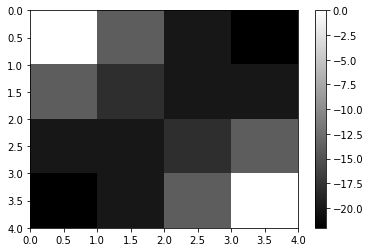

In [8]:
def plot_gridworld_value(V):
    plt.figure()
    c = plt.pcolormesh(V, cmap='gray')
    plt.colorbar(c)
    plt.gca().invert_yaxis()  # In the array, first row = 0 is on top

# Making a plot always helps
plot_gridworld_value(V.reshape(env.shape))

In [9]:
# Test: When you hand in the nodebook we will check that the value function is (approximately) what we expected
# but we need to make sure it is at least of the correct shape
v = policy_eval(random_policy, env)
assert v.shape == (env.nS)

---
## 2. Policy Iteration (2 points)
Using the policy evaluation algorithm we can implement policy iteration to find a good policy for this problem. Note that we do not need to use a discount_factor for episodic tasks but make sure your implementation can handle this correctly!

In [10]:
def calc_Q(state, V, discount_factor):
    """Calculates the Q(s, a) values for a state.
    
    Args:
        state: (int) the index of the state which Q values are of interest.
        V: (np.array) estimated V values.
        discount_factor: (float <=1) the discouting factor for the reward of future states.
        
    Returns:
        (np.array of shape env.nA) with the estimated Q values."""
    
    Q = np.zeros(env.nA)
    
    for action in range(env.nA):
        for trans_prob, next_state, reward, done in env.P[state][action]:
            Q[action] += trans_prob * (reward + discount_factor * V[next_state])
            
    return Q

def policy_improvement(env, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Chapter 4, pag 80 from Sutton
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    converged = False
    
    while not converged:
        
        V = policy_eval(policy, env, discount_factor)
        
        converged = True
        
        for state in range(env.nS):
            
            # get the greedy action for the curent state 
            # under the current policy
            greedy_action = np.argmax(policy[state])
            
            Q = calc_Q(state, V, discount_factor)
            
            # get the best action for the curent state 
            # given the current estimations of Q(a | s)
            best_action = np.argmax(Q)
            
            policy[state] = np.eye(env.nA)[best_action]
            
            # If nothing changes, the while-loop is exited.
            if greedy_action != best_action:
                converged = False
    
    return policy, V

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



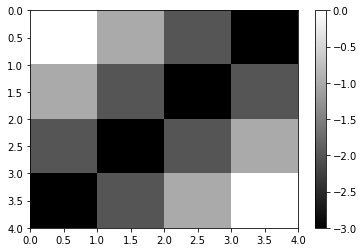

In [11]:
# Let's see what it does
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

def print_grid_policy(policy, symbols=["^", ">", "v", "<"]):
    symbols = np.array(symbols)
    for row in policy:
        print("".join(symbols[row]))

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

plot_gridworld_value(v.reshape(env.shape))

In [12]:
# This is not an empty cell. It is needed for grading.

---
## 3. Value Iteration (3 points)
Now implement the value iteration algorithm.

In [13]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    Implementation of the algorithm as described at Sutto book Ch 4, pag 83.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    

    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA])
    
    # Arbitrary initialization to enter the while loop.
    max_delta = theta + 1
    
    while max_delta > theta:
        
        max_delta = 0
        
        # Calculates the Value of all states V[:]
        for state in range(env.nS):
            
            # Get the Q(a | s) 
            Q = calc_Q(state, V, discount_factor)
            
            # get the value of the action with maximum value.
            v_best = np.max(Q)
            
            # necessary for the while-loop exit condition
            delta = np.abs(v_best - V[state])
            
            # the value of the state is the same as 
            # the value of the best action.
            V[state] = v_best      
            
        # Refreshes the stoping criteria.
        max_delta = delta if delta > max_delta else max_delta 
        
    # Deterministic greedy policy:
    # Is there a way of doing it without a loop?
    for state in range(env.nS):

        # Find the greedy action.
        Q = calc_Q(state, V, discount_factor)
        best_action = np.argmax(Q)
        
        # Set the probability of the greedy action to 1.
        policy[state, best_action] = 1.0
    
    return policy, V

In [14]:
# Oh let's test again
# Let's see what it does
policy, v = value_iteration(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")


Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 0 0]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 1 0]]
^<^^
^^^^
^^^v
^^>^

Value Function:
[ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1.  0.]]



What is the difference between value iteration and policy iteration? Which algorithm is most efficient (e.g. needs to perform the least *backup* operations)? Please answer *concisely* in the cell below.

Policy Iteration requires a policy evaluation step at each iteration, which is itself iteractive. Value iteration goes around it by only performing one sweep of the policy evaluation. Value Iteration is also guaranteed to converge under the same conditions of Policy Iteration.

Value Iteration is more efficiently because it requires a fewer number of computations per iteration.

## 4. Monte Carlo Prediction (7 points)
What is the difference between Dynamic Programming and Monte Carlo? When would you use the one or the other algorithm?

Dynamic Programming looks at all actions and their resulting states to update the value of the current state. Monte Carlo on the otherside considers at a full episode to update the value of a state.
Dynamic Programming requires to have a model then tells whichs state one ends up in after performing an action in the current state. Monte Carlo does not require that model however it is limited to episodic problems since it only updates values after completing an episode.

For the Monte Carlo Prediction we will look at the Blackjack game (Example 5.1 from the book), for which the `BlackjackEnv` is implemented in `blackjack.py`. Note that compared to the gridworld, the state is no longer a single integer, which is why we use a dictionary to represent the value function instead of a numpy array. By using `defaultdict`, each state gets a default value of 0.

In [15]:
from blackjack import BlackjackEnv
env = BlackjackEnv()

For the Monte Carlo algorithm, we need to *interact* with the environment. This means that we start an episode by using `env.reset` and send the environment actions via `env.step` to observe the reward and next observation (state).

In [16]:
# So let's have a look at what we can do in general with an environment...
import gym
?gym.Env

In [17]:
# We can also look at the documentation/implementation of a method
?env.step

In [18]:
??BlackjackEnv

A very simple policy for Blackjack is to *stick* if we have 20 or 21 points and *hit* otherwise. We want to know how good this policy is. This policy is *deterministic* and therefore a function that maps an observation to a single action. Technically, we can implement this as a dictionary or as a function, where we use the latter. To get started, let's implement this simple policy for BlackJack.

In [19]:
def simple_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    sum_hand = observation[0]
    return sum_hand < 20

In [20]:
s = env.reset()
print(s)
a = simple_policy(s)
print(env.step(a))

(20, 8, False)
((20, 8, False), 1, True, {})


Now implement either the MC prediction algorithm (either first visit or every visit). Hint: you can use `for i in tqdm(range(num_episodes))` to show a progress bar.

In [21]:
from collections import defaultdict

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i in tqdm(range(num_episodes)):
        # Generate episode
        done = False
        episode = []
        while not done:
            s = env.reset()
            a = policy(s)
            new_s, reward, done, _ = env.step(a)
            episode.append((s, a, reward))
        
        G = 0
        for i, (s, a, r) in enumerate(episode[::-1]):
            G = discount_factor * G + r
            
            # check if it first visit <=> no earlier step with same state
            earlier_steps = list(filter(lambda step: step[0] == 1,episode[:-i]))
            first_visit = len(earlier_steps) == 0
            
            if first_visit:
                returns_sum[s] = returns_sum[s] + G
                returns_count[s] = returns_count[s] + 1
                V[s] = returns_sum[s] / returns_count[s]
    
    return V

In [22]:
V = mc_prediction(simple_policy, env, num_episodes=1000)
print(V)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6687.06it/s]


defaultdict(<class 'float'>, {(20, 5, False): 0.8095238095238095, (13, 9, False): -0.8, (14, 10, False): -0.8076923076923077, (17, 10, False): -0.5853658536585366, (17, 8, False): -0.7692307692307693, (16, 10, True): -0.45454545454545453, (21, 10, True): 0.8648648648648649, (12, 5, False): -0.4117647058823529, (20, 9, False): 0.75, (18, 4, False): -1.0, (15, 10, True): 0.3333333333333333, (18, 10, False): -0.9230769230769231, (21, 6, False): 0.3333333333333333, (14, 7, False): -0.7142857142857143, (15, 8, False): -0.6153846153846154, (15, 1, False): -1.0, (13, 3, False): -1.0, (19, 1, False): -1.0, (12, 7, False): -0.5, (12, 10, False): -0.4807692307692308, (14, 2, False): -0.8823529411764706, (20, 2, True): -1.0, (14, 5, False): -0.9444444444444444, (16, 1, False): -0.6842105263157895, (20, 1, False): 0.05263157894736842, (12, 8, False): -0.47619047619047616, (17, 6, True): 1.0, (21, 2, True): 0.8, (14, 1, False): -0.8181818181818182, (20, 8, False): 0.8571428571428571, (15, 10, False

Now make *4 plots* like Figure 5.1 in the book. You can either make 3D plots or heatmaps. Make sure that your results look similar to the results in the book. Give your plots appropriate titles, axis labels, etc.

In [23]:
%%time
# Let's run your code one time
V_10k = mc_prediction(simple_policy, env, num_episodes=10000)
V_500k = mc_prediction(simple_policy, env, num_episodes=500000)

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [01:10<00:00, 7131.49it/s]


Wall time: 1min 11s


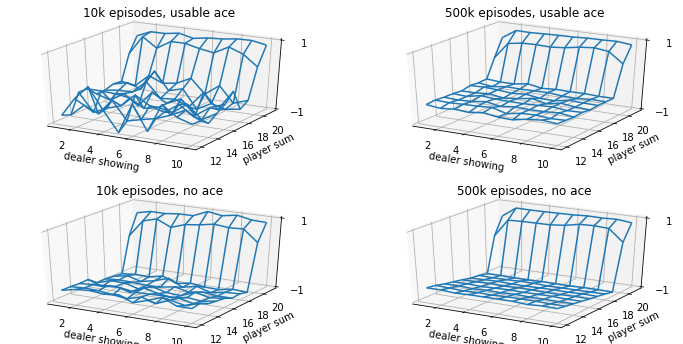

In [24]:
# YOUR CODE HERE
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

# dealer value range
d_range = range(1, 11)
# player value range
p_range = range(12, 22)
# usable ace range
ace_range = [True, False]

X = np.array([list(d_range)] * len(p_range)).T
Y = np.array([list(p_range)] * len(d_range))
Zs = np.zeros((4, X.shape[0], X.shape[1]))
titles = ['10k episodes, usable ace', '500k episodes, usable ace', '10k episodes, no ace', '500k episodes, no ace']

for i, d in enumerate(d_range):
    for j, p in enumerate(p_range):
        Zs[0,i,j] = V_10k[(p, d, True)]
        Zs[1,i,j] = V_500k[(p, d, True)]
        Zs[2,i,j] = V_10k[(p, d, False)]
        Zs[3,i,j] = V_500k[(p, d, False)]
            
fig = plt.figure(figsize=(12,6))
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.plot_wireframe(X, Y, Zs[i])
    ax.set_zlim(-1,1)
    ax.set_zticks([-1,1])
    ax.set_title(titles[i])
    ax.set_xlabel('dealer showing')
    ax.set_ylabel('player sum')
    

plt.show()

## 5. Monte Carlo control with $\epsilon$-greedy policy (5 points)
Now we have a method to evaluate state-values given a policy. Take a moment to think whether we can use the value function to find a better policy? Assuming we do not know the dynamics of the environment, why is this not possible?

We want a policy that selects _actions_ with maximum value, e.g. is _greedy_ with respect to the _action-value_ (or Q-value) function $Q(s,a)$. We need to keep exploring, so with probability $\epsilon$ we will take a random action. First, lets implement a function `make_epsilon_greedy_policy` that takes the Q-value function and returns an $\epsilon$-greedy policy. The policy itself is a function that returns an action.

In [25]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        an action according to the epsilon-greedy policy.
    
    """
    def policy_fn(observation):
        
        # All policies receive epsilon / nA probability
        p_all = np.array([epsilon / nA] * nA)
        
        # Define the probability to be added to the greedy action
        p_greedy = 1 - epsilon
        
        # Finds the action with max Q value
        greedy_idx = np.argmax(Q[observation])
        
        p_all[greedy_idx] += p_greedy
        
        assert np.sum(p_all) == 1.0
        
        return p_all

    return policy_fn

In [26]:
from collections import defaultdict
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Again, keep track of counts for efficiency
    # returns_sum, returns_count and Q are 
    # nested dictionaries that map state -> (action -> action-value).
    # We could also use tuples (s, a) as keys in a 1d dictionary, but this
    # way Q is in the format that works with make_epsilon_greedy_policy
    
    # Not sure what to do with that!
#     returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
#     returns_count = defaultdict(lambda: np.zeros(env.action_space.n, dtype=int))
    
    # The final action-value function.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    returns_SA = {}

    max_steps = 10
    
    for ep in tqdm(range(num_episodes)):
        
        episode = []  # (state, action, reward, first_visit)
        state = env.reset()
        
        # Necessary?
        unique_SA = set() # tracks the (state, action)
        
        # Set the stopying criteria.
        done = False
        step = max_steps  # Avoids episodes that are too long.
        
        # Generate an episode.
        while not done:
            
            # defines an action
            p_all = policy(state)
            action = np.random.choice(np.arange(len(p_all)), p=p_all)
            
            # tracks if this state was visited before
            first_visit = True
            if (state, action) in unique_SA:
                first_visit = False
            else:
                unique_SA.add((state, action))
            
            # transitions to a next state, given the chosen action
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward, first_visit))
            state = next_state
            
            # Safety stop criteria
            step -= 1
            if step <= 0:
                break
        
        # Initial total reward of the episode is zero.
        G = 0 
        
        for idx, (state, action, reward, first_visit) in enumerate(reversed(episode)):
            sa_pair = (state, action)
            
            # Calculate the expected reward of (state, action)
            G = discount_factor * G + reward
            
            if first_visit:
                # average reward of (state, action), number of visits so far
                q_sa, n_iter = returns_SA.get(sa_pair, (0, 0))
                n_iter += 1  # Updates the number of times this (state, action) was encontered

                # Iteratively updates the averages
                returns_SA[sa_pair] = (q_sa + (G - q_sa) / n_iter, n_iter)

                Q[state][action] = returns_SA[sa_pair][0]
            else:
                print(f"another visit: {idx}, {state}, {action}, {reward}, {G}")

    return Q, policy
    
# Test it quickly
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4664.54it/s]


In [27]:
%%time
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [01:54<00:00, 4371.30it/s]


Wall time: 1min 54s


How can you obtain the (V-)value function from the Q-value function? Plot the (V-)value function that is the result of 500K iterations. Additionally, visualize the greedy policy similar to Figure 5.2 in the book. Use a white square for hitting, black for sticking.

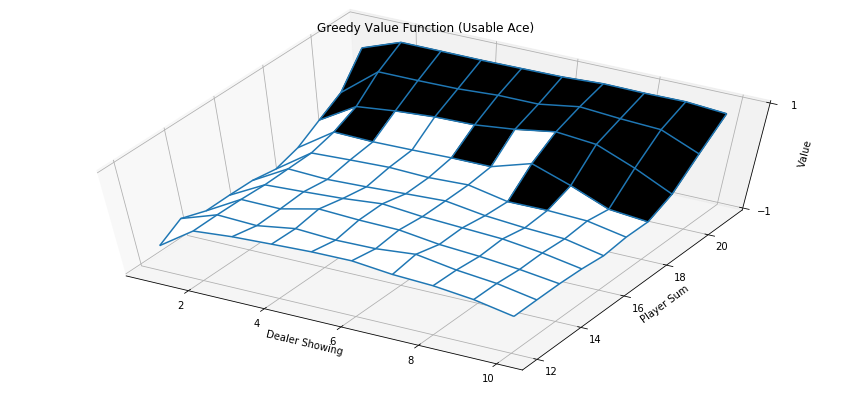

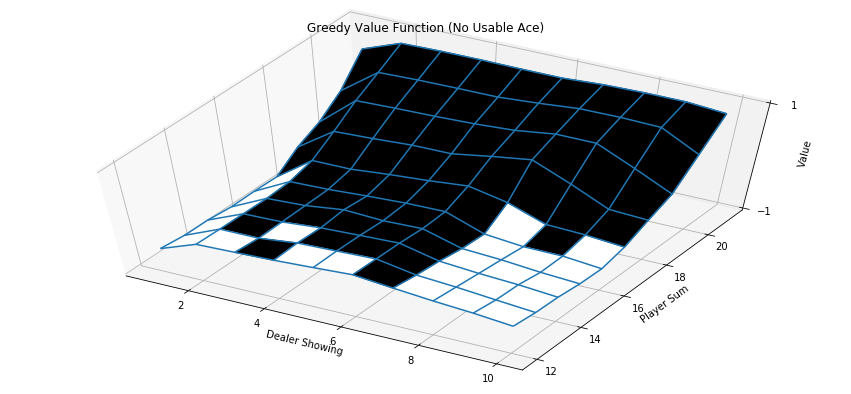

In [28]:
import seaborn as sns

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Copied from https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py

def get_Z(X, Y, use_ace=True):
    return np.apply_along_axis(lambda x: V[(x[1], x[0], use_ace)], 2, np.dstack([X, Y]))

def color_from_action(X, Y, A, use_ace=True):
    c = np.apply_along_axis(lambda x: A[(x[1], x[0], use_ace)], 2, np.dstack([X, Y]))
    
    return c.astype(str)

def blackjack_plot(V, A, use_ace=True, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    
    # X axis keeps the sum of the Dealer
    x_range = np.arange(min(k[1] for k in V.keys()), max(k[1] for k in V.keys())+1)
    
    # Y axis keeps the sum of the player
    y_range = np.arange(min(k[0] for k in V.keys()), max(k[0] for k in V.keys())+1)
    
    
    # Define a meshgrid
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z = get_Z(X, Y, use_ace)
    
    a_colors = color_from_action(X, Y, A, use_ace)

    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(X, Y, Z, facecolors= a_colors , vmin=-1.0, vmax=1.0, shade=False) # plt.cm.jet(a_colors)
    surf = ax.plot_wireframe(X, Y, Z,)
    
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    ax.set_zlabel('Value')
    ax.set_title(title)
    ax.view_init(60, -60)
    ax.set_zticks([-1,1])
    ax.set_zlim(-1,1)
    plt.show()

V = defaultdict(float)
A = defaultdict(float)

# We only care for the greedy action of each state.
for state in Q:
    action = Q[state]
    V[state] = np.max(action)  # get the value of the greedy action.
    A[state] = np.argmax(action)  # get the greedy action.

blackjack_plot(V, A, use_ace=True, title="Greedy Value Function (Usable Ace)")
blackjack_plot(V, A, use_ace=False, title="Greedy Value Function (No Usable Ace)")